In [1]:
import pandas as pd
import geopandas as gpd
import rasterio
from rasterio.features import rasterize
from shapely.geometry import box
from shapely.geometry import Polygon, Point
import matplotlib.pyplot as plt

# Folder path
directory_path = 'D:/!!Research/!!!Data/ArcGIS_Projects/mesq_prediction/test_mesq_prediction_points'

C:\Users\Justin\AppData\Local\Temp\ipykernel_16428\3717803760.py:1: DeprecationWarning: 
Pyarrow will become a required dependency of pandas in the next major release of pandas (pandas 3.0),
(to allow more performant data types, such as the Arrow string type, and better interoperability with other libraries)
but was not found to be installed on your system.
If this would cause problems for you,
please provide us feedback at https://github.com/pandas-dev/pandas/issues/54466
        
  import pandas as pd


#### CSV to points

In [17]:
# Load the CSV file into a pandas DataFrame
df = pd.read_csv(f'{directory_path}/poly47/poly47_centroids_xgb_prediction.csv')


# Turning the target class into an integer representing a percentage to save space.
df['prob_class_1'] = df['prob_class_1'].mul(100).astype(int)
df = df.rename(columns = {'prob_class_1' : 'prob_mesq'})

# Assuming your CSV has 'longitude' and 'latitude' columns
# Create a 'geometry' column with Point geometries
df['geometry'] = df.apply(lambda row: Point(row['longitude'], row['latitude']), axis=1)

# Convert the DataFrame to a GeoDataFrame
gdf = gpd.GeoDataFrame(df, geometry='geometry')

# Set the Coordinate Reference System (CRS) to WGS84 (EPSG:4326) or any appropriate CRS
gdf.set_crs(epsg=6350, inplace=True)

# Save to a new shapefile if needed
gdf.to_file(f'{directory_path}/poly47/joins_and_such/poly47_centroids_pred.shp')

print("Conversion complete.")
gdf.head()

C:\Users\Justin\AppData\Local\Temp\ipykernel_16428\637548707.py:20: UserWarning: Column names longer than 10 characters will be truncated when saved to ESRI Shapefile.
  gdf.to_file(f'{directory_path}/poly47/joins_and_such/poly47_centroids_pred.shp')


Conversion complete.


,system:index,latitude,longitude,predictions,prob_class_0,prob_mesq,geometry
0,0,1194667,-735049,1,0.042785,95,POINT (-735049.000 1194667.000)
1,1,1194647,-735052,1,0.051444,94,POINT (-735052.000 1194647.000)
2,2,1194647,-735069,1,0.051444,94,POINT (-735069.000 1194647.000)
3,3,1194646,-735065,1,0.051444,94,POINT (-735065.000 1194646.000)
4,4,1194638,-735072,1,0.047032,95,POINT (-735072.000 1194638.000)


#### Spatial join

In [18]:
# Load the polygon data
polygons = gpd.read_file(f'{directory_path}/poly47/joins_and_such/poly47_rast_to_poly.shp')

# Load the point data
points = gpd.read_file(f'{directory_path}/poly47/joins_and_such/poly47_centroids_pred.shp')

# Ensure both GeoDataFrames use the same CRS
if points.crs != polygons.crs:
    points = points.to_crs(polygons.crs)

# Buffer the polygons by 2 meters
polygons['geometry'] = polygons.geometry.buffer(2)

# Perform the spatial join
joined = gpd.sjoin(points, polygons, how='inner', predicate='within')

# Apply a negative buffer to shrink the polygons by 2 meters
joined['geometry'] = joined['geometry'].buffer(-2)

# Aggregate attributes within each polygon
# Here, we sum the attribute values of points within each polygon
aggregated = joined.groupby('index_right').agg({'prob_mesq': 'mean'})
aggregated['prob_mesq'] = aggregated['prob_mesq'].astype(int)

aggregated.head()

,prob_mesq
index_right,
0,89
1,89
2,42
3,87
4,42


In [19]:
# Merge aggregated attributes back to the polygons GeoDataFrame
polygons = polygons.merge(aggregated, left_index=True, right_index=True, how='left')

# Fill NaN values with 0 (in case some polygons have no points within them)
polygons['prob_mesq'] = polygons['prob_mesq'].fillna(0)

# Save the result to a new shapefile
polygons.to_file(f'{directory_path}/poly47/joins_and_such/poly47_join.shp')

print("Spatial join complete.")

Spatial join complete.


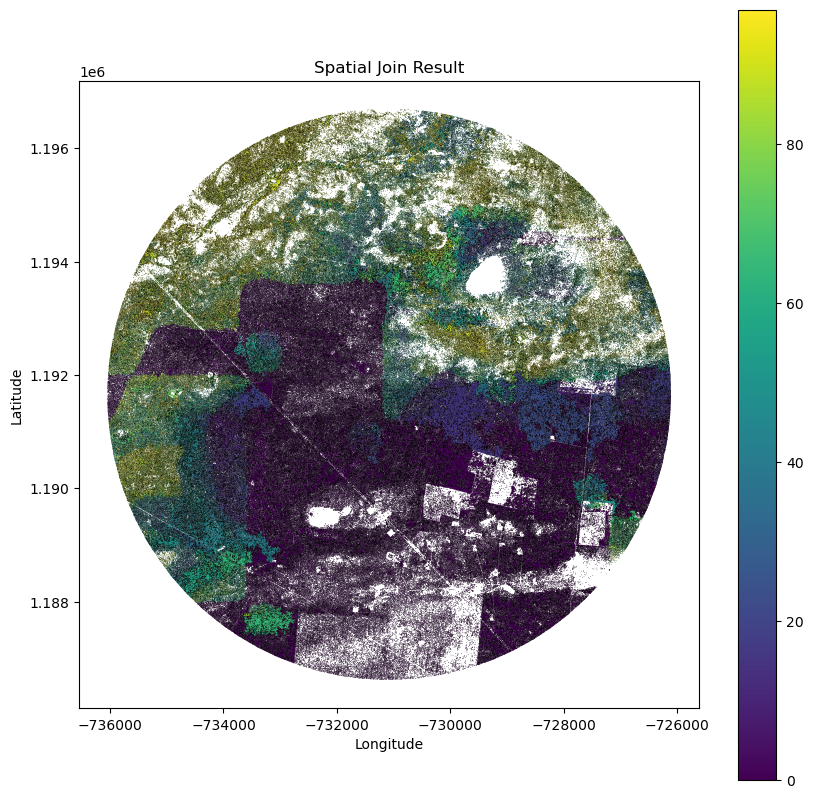

In [20]:
joined = gpd.read_file(f'{directory_path}/poly47/joins_and_such/poly47_join.shp')

# Plot the joined GeoDataFrame
fig, ax = plt.subplots(figsize=(10, 10))

# Plot the polygons with a boundary line
joined.boundary.plot(ax=ax, linewidth=0.1, color='black')

# Plot the points
joined.plot(column='prob_mesq', ax=ax, legend=True, cmap='viridis', markersize=5)

# Customize the plot
plt.title('Spatial Join Result')
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.grid(False)
plt.show()

#### Rasterization

In [22]:
# Load the polygon data
gdf = gpd.read_file(f'{directory_path}/poly47/joins_and_such/poly47_join.shp')

# Define the extent and resolution
minx, miny, maxx, maxy = gdf.total_bounds
resolution = 1  # Define appropriate resolution

width = int((maxx - minx) / resolution)
height = int((maxy - miny) / resolution)
transform = rasterio.transform.from_origin(minx, maxy, resolution, resolution)

# Rasterize the geometries
raster = rasterize(
    [(geom, value) for geom, value in zip(gdf.geometry, gdf['prob_mesq'])],
    out_shape=(height, width),
    transform=transform,
    fill=999,  # Value for areas not covered by any polygon
    dtype='int32'
)

# Save the raster to a file
with rasterio.open(
    f'{directory_path}/poly47/rasters/poly47_predictions.tif',
    'w',
    driver='GTiff',
    height=height,
    width=width,
    count=1,
    dtype=rasterio.int32,
    crs=gdf.crs,
    transform=transform,
) as dst:
    dst.write(raster, 1)

print("Rasterization complete.")

Rasterization complete.


Displaying

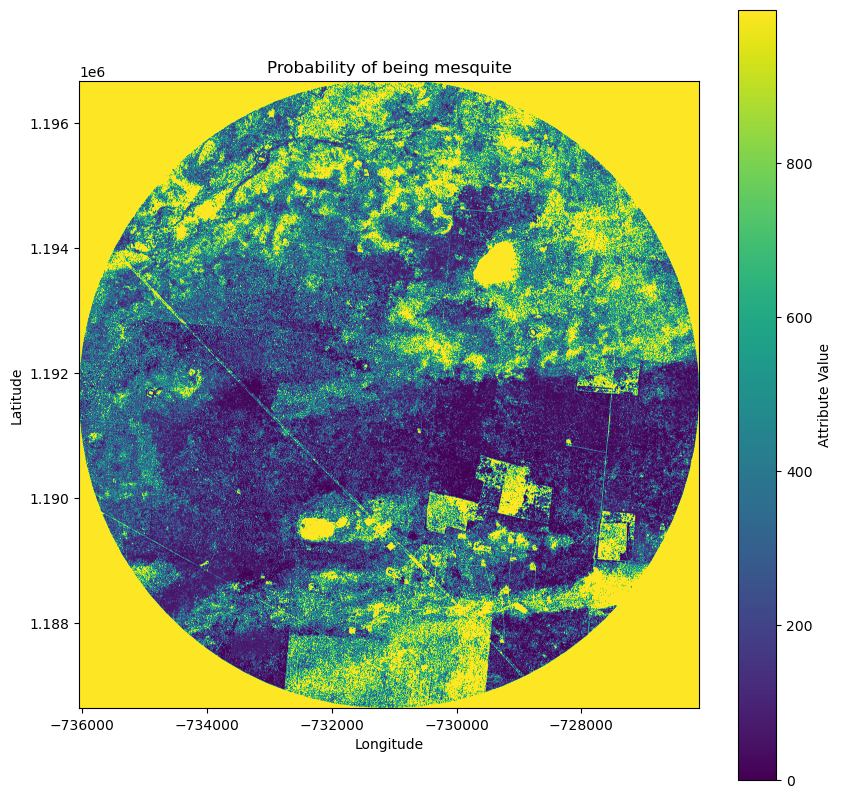

In [23]:
# Open the raster file
raster_file = f'{directory_path}/poly47/rasters/poly47_predictions.tif'
with rasterio.open(raster_file) as src:
    raster_data = src.read(1)  # Read the first band
    extent = (src.bounds.left, src.bounds.right, src.bounds.bottom, src.bounds.top)

# Display the raster data
plt.figure(figsize=(10, 10))
plt.imshow(raster_data, cmap='viridis', extent=extent)
plt.colorbar(label='Attribute Value')
plt.title('Probability of being mesquite')
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.grid(False)
plt.show()